In [1]:
########################################################
#                Problem Description                   #
# Predict Google stock price for the month of Jan 2017 #
# using the data for the past 1258 days                #
########################################################

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [17]:
dataset_train = pd.read_csv('Google_Stock_Price_Train.csv')
print dataset_train.head()
training_set = dataset_train.iloc[:, 1:2].values
training_set.shape

       Date    Open    High     Low   Close      Volume
0  1/3/2012  325.25  332.83  324.97  663.59   7,380,500
1  1/4/2012  331.27  333.87  329.08  666.45   5,749,400
2  1/5/2012  329.83  330.75  326.89  657.21   6,590,300
3  1/6/2012  328.34  328.77  323.68  648.24   5,405,900
4  1/9/2012  322.04  322.29  309.46  620.76  11,688,800


(1258, 1)

In [3]:
# Scaling should always be applied for 
# Deep Learning models

from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
training_set_scaled = sc.fit_transform(training_set)

In [8]:
# the memory of RNN depends on the number of timesteps you select
# if timesteps = x then the output depends on the previous x inputs

# Create input set that consists of 60 dimensions
# hence, the output of current day will be based on 
# the prices of previous 60 days

X_train = []
y_train = []
for i in range(60, 1258):
    X_train.append(training_set_scaled[i - 60: i, 0])
    y_train.append(training_set_scaled[i, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape : convert our 2D array to 3D
(batch_size, timesteps) = X_train.shape
# This is done because the RNN class in Keras expects a 
# 3D Tensor
X_train = np.reshape(X_train, (batch_size, timesteps, 1))

In [9]:
# Building RNN
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [15]:
# Initialise Sequential model
regressor = Sequential()

# units is the output dimensionality
# return sequences will return the sequence
# which will be required to the next LSTM 

# input shape will need only the last 2 dimensions
# of your input
################# 1st layer #######################
regressor.add(LSTM(units=50, return_sequences=True, 
                   input_shape=(timesteps, 1)))

# add Dropout to do regulariztion
# standard practise to use 20%
regressor.add(Dropout(0.2))

################# 2nd layer ######################
# After the first time, it's not required to 
# specify the input_shape

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))


################# 3rd layer ######################
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
              

################# 4th layer ######################
# the last layer needn't return the sequence, so
# return_sequences will be False
              
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))

################# 5th layer ######################
# Last layer would be the fully connected layer,
# or the Dense layer
#
# The last word will predict a single number
# hence units=1

regressor.add(Dense(units=1))
              
# Compiling the RNN
# The loss function for classification problem is 
# cross entropy, since this is a regression problem
# the loss function will be mean squared error
              
regressor.compile(optimizer='adam', loss='mean_squared_error')


In [16]:
regressor.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
1198/1198 [==============================] - 14s 12ms/step - loss: 0.0525
Epoch 2/100
1198/1198 [==============================] - 10s 9ms/step - loss: 0.0056
Epoch 3/100
1198/1198 [==============================] - 11s 9ms/step - loss: 0.0054
Epoch 4/100
1198/1198 [==============================] - 12s 10ms/step - loss: 0.0054
Epoch 5/100
1198/1198 [==============================] - 22s 18ms/step - loss: 0.0049
Epoch 6/100
1198/1198 [==============================] - 36s 30ms/step - loss: 0.0053
Epoch 7/100
1198/1198 [==============================] - 35s 29ms/step - loss: 0.0047
Epoch 8/100
1198/1198 [==============================] - 35s 30ms/step - loss: 0.0043
Epoch 9/100
1198/1198 [==============================] - 36s 30ms/step - loss: 0.0054
Epoch 10/100
1198/1198 [==============================] - 29s 24ms/step - loss: 0.0042
Epoch 11/100
1198/1198 [==============================] - 10s 9ms/step - loss: 0.0041
Epoch 12/100
1198/1198 [==============================]

In [19]:
# Persisting the model for future use
from keras.models import load_model
# Save
regressor.save('regressor.hd5')
# Load
# model = load_model('regressor.hd5')

In [27]:
# Preparing test data
dataset_test = pd.read_csv('Google_Stock_Price_Test.csv')
print dataset_test.head()
real_stock_prices = dataset_test.iloc[:, 1:2].values

       Date    Open    High     Low   Close     Volume
0  1/3/2017  778.81  789.63  775.80  786.14  1,657,300
1  1/4/2017  788.36  791.34  783.16  786.90  1,073,000
2  1/5/2017  786.08  794.48  785.02  794.02  1,335,200
3  1/6/2017  795.26  807.90  792.20  806.15  1,640,200
4  1/9/2017  806.40  809.97  802.83  806.65  1,272,400


In [28]:
# Preparing test dataset
#
# To predict the price for 3 Jan '17 (first financial
# day) we will need the price for 60 days before that, 
# so we will need both, the train and the test set to
# gather the required data

# 1. Concatenate training and test set

dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']),
                         axis=0) # axis=0 is concatenate rows

# 2. For each day from 1st Jan get 60 previous 
#    days' data

first_day_index = len(dataset_total) - len(dataset_test)
inputs = dataset_total[first_day_index - 60: ].values
inputs = inputs.reshape(-1, 1)

# 3. Scale the input

inputs = sc.transform(inputs)

In [29]:
# Prepare the dataset to have 60 dimensions
X_test = []
for i in range(60, 80):
    X_test.append(inputs[i - 60: i, 0])
X_test = np.array(X_test)

# Reshape : convert our 2D array to 3D
(batch_size, timesteps) = X_test.shape
# This is done because the RNN class in Keras expects a 
# 3D Tensor
X_test = np.reshape(X_test, (batch_size, timesteps, 1))

In [30]:
# Making prediction
predicted_stock_price = regressor.predict(X_test)
# inverse the scaling
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

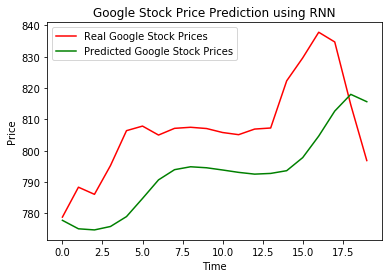

In [31]:
# Visualing the results
plt.plot(real_stock_prices, color='red', 
         label='Real Google Stock Prices')
plt.plot(predicted_stock_price, color='green',
         label='Predicted Google Stock Prices')
plt.title('Google Stock Price Prediction using RNN')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()